In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import pickle
import clean_data

model_cols = ['BSTAR', 'INCLINATION', 'RA_OF_ASC_NODE', 'ECCENTRICITY', 'ARG_OF_PERICENTER', 'MEAN_ANOMALY',
              'MEAN_MOTION', 'epoch_jd', 'epoch_fr',
              #'MEAN_MOTION_DOT', 'MEAN_MOTION_DDOT', 
             ]

def clean_df(df):
    df = clean_data.add_epoch_data(df)
    df = clean_data.normalize_all_columns(df)
    return df

def clean_all(train_df, test_df):
    train_df = clean_df(train_df)
    test_df = clean_df(test_df)
    return train_df,test_df

def load_all():
    train_df = pd.read_pickle(os.environ['GP_HIST_PATH'] + '/raw_compiled/train.pkl' ) # Time: 25.7s
    #test_df = pd.read_pickle(os.environ['GP_HIST_PATH'] + '/raw_compiled/test.pkl' ) # Time: 5
    return train_df #, test_df

train_df = load_all()
#train_df,test_df = clean_all(train_df, test_df)

|NORAD|Count of TLEs|
|-|-|
|3506|     19285|
|10839|    19557|
|3938|     19724|
|8142|     20576|
|14631|    21571|

In [2]:
train_df = train_df[train_df['NORAD_CAT_ID'] == 14631].reset_index(drop=True)
train_df = clean_df(train_df)
train_model_df = train_df[model_cols]
idx_map = clean_data.create_index_map(train_df)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 77.12it/s]


In [3]:
split = 0.8
train_idx_map = idx_map[:int(len(idx_map)*split)]
test_idx_map = idx_map[int(len(idx_map)*split):]

In [58]:
import train

model = train.create_model(model_cols=model_cols,
                           layer1=100, relu1=True, #drop1=0.5,
                           layer2=200, relu2=True, #drop2=0.5,
                           layer3=100, relu3=True, #drop3=0.5,
                          )
model

NNModelEx(
  (net): Sequential(
    (0): Linear(in_features=11, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU()
    (6): Linear(in_features=100, out_features=7, bias=True)
    (7): ReLU()
  )
)

In [59]:
%%time
device='cpu'
trained_model, loss_output = train.train_model(train_model_df, train_idx_map, batchSize=2000,
                                               print_itr=8, numEpochs=50, model_cols=model_cols,
                                               learningRate=0.0001, device=device, num_workers=10,
                                               loss='L2', model=model)

>>> Loading dataset
>>> Beginning training!
Epoch [1/50], Batch [8/8], Loss: 0.46470892429351807, Time: 4s
Epoch [2/50], Batch [8/8], Loss: 0.4497573971748352, Time: 3s
Epoch [3/50], Batch [8/8], Loss: 0.44774380326271057, Time: 3s
Epoch [4/50], Batch [8/8], Loss: 0.42771637439727783, Time: 3s
Epoch [5/50], Batch [8/8], Loss: 0.41903263330459595, Time: 3s
Epoch [6/50], Batch [8/8], Loss: 0.4175347089767456, Time: 3s
Epoch [7/50], Batch [8/8], Loss: 0.38996002078056335, Time: 3s
Epoch [8/50], Batch [8/8], Loss: 0.3771381974220276, Time: 4s
Epoch [9/50], Batch [8/8], Loss: 0.3674111068248749, Time: 3s
Epoch [10/50], Batch [8/8], Loss: 0.36324045062065125, Time: 3s
Epoch [11/50], Batch [8/8], Loss: 0.363108366727829, Time: 3s
Epoch [12/50], Batch [8/8], Loss: 0.3604317903518677, Time: 3s
Epoch [13/50], Batch [8/8], Loss: 0.3615594208240509, Time: 3s
Epoch [14/50], Batch [8/8], Loss: 0.36405301094055176, Time: 3s
Epoch [15/50], Batch [8/8], Loss: 0.3609209358692169, Time: 3s
Epoch [16/50],

In [60]:
X_test,y_test = clean_data.build_xy(train_model_df,test_idx_map)  # create input/label pair
y_pred = train.predict(trained_model, X_test, device=device) # get predictions for each train
y_pred_df = pd.DataFrame(y_pred, columns=train_model_df.columns[:-2])  # put results into a dataframe

    Test set MAE (L1) loss: 0.3128305374897057
    Test set MSE (L2) loss: 0.32392226236647353


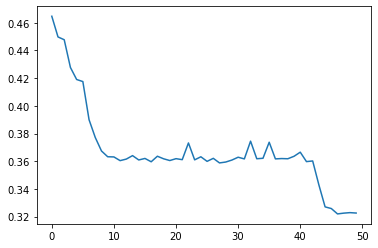

In [61]:
print(f'    Test set MAE (L1) loss: {mean_absolute_error(y_test, y_pred_df)}')
print(f'    Test set MSE (L2) loss: {mean_squared_error(y_test, y_pred_df)}')

plt.plot([float(l['loss']) for l in loss_output])

In [62]:
clean_data.normalize_all_columns(y_test.head().copy(), reverse=True)  # see ground truths

,BSTAR,INCLINATION,RA_OF_ASC_NODE,ECCENTRICITY,ARG_OF_PERICENTER,MEAN_ANOMALY,MEAN_MOTION
0,0.000153,97.6861,60.8571,0.001215,10.7422,349.3993,15.176369
1,0.000129,97.5888,128.8429,0.002763,358.0993,2.0220,14.933894
2,0.000020,97.7594,92.8526,0.000794,182.7289,177.3910,15.325660
3,0.000028,97.6890,220.3386,0.001340,14.6090,345.5537,15.129359
4,0.000021,97.7221,45.9007,0.000723,205.4182,154.6705,15.330698


In [63]:
clean_data.normalize_all_columns(y_pred_df.head().copy(), reverse=True)  # See predictions

,BSTAR,INCLINATION,RA_OF_ASC_NODE,ECCENTRICITY,ARG_OF_PERICENTER,MEAN_ANOMALY,MEAN_MOTION
0,0.0,98.751923,181.713852,0.001526,174.438965,181.769333,13.75
1,0.0,98.242180,181.193008,0.002119,175.407593,178.679062,13.75
2,0.0,94.530731,172.923492,0.001636,165.519028,170.432663,13.75
3,0.0,98.142593,184.278809,0.001762,175.125824,184.066742,13.75
4,0.0,97.019684,183.921234,0.001054,170.612717,184.613998,13.75
